In [1]:
# python
import os, sys, pickle
from itertools import combinations_with_replacement
from collections import OrderedDict

# stats
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from statsmodels.api import OLS

# plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# neural networks
import torch, torch.utils.model_zoo # required to load nets
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

# analysis code
from lib.transforms import VisualPriorRepresentation
from lib.functions_second_analysis import *

DATASET_NAMES               = ('places1', 'places2', 'oasis')
SCALE_NAMES                 = ('scale2','scale4','scale8','scale16','scale32')
STUDY_NAMES                 = ("short presentation", "long presentation", "complexity order")
BEHAVIOUR_NAMES             = ('study1_places1_short.csv','study2_places1.csv','study3_places2.csv','study4_oasis.csv')

PATH_IMAGES                 = '../images and ratings/imageversions_256'
PATH_RATINGS                = '../images and ratings/ratings'
PATH_INTEGRATION = (
    "../data csv/integration"  # !! correlations, invert sign for integration
)
PATH_INTEGRATION_BLOCKED = (
    "../data csv/integration blocked"  # !! correlations, invert sign for integration
)
PATH_IBCORR = "../data csv/ibcorr"
PATH_IBCORR_UNBLOCKED_INT = "../data csv/ibcorr unblocked_int"
PATH_IBCORR_BLOCKED_INT = "../data csv/ibcorr blocked_int"

PATH_RESULTS                = '../results'
PATH_PLOTS                  = '../plots'

#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')

# load data
one click, import all data

In [2]:
# integration

# unblocked
cl = []
for mo in MODEL_NAMES:
    for da in DATASET_NAMES:
        for sc in SCALE_NAMES:
            c = (
                pd.read_csv(
                    os.path.join(PATH_INTEGRATION, mo, da, sc, "correlations.csv"),
                    header=None,
                )
                .assign(scale=sc)
                .assign(dataset=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )
            cl.append(c)
# correlation to integration
dfi = -pd.concat(cl).set_index(["model", "dataset", "scale", "img"])


# blocked
cl = []
for mo in MODEL_NAMES:
    for da in DATASET_NAMES:
        for sc in SCALE_NAMES:
            c = (
                pd.read_csv(
                    os.path.join(
                        PATH_INTEGRATION_BLOCKED, mo, da, sc, "correlations.csv"
                    ),
                    header=None,
                )
                .assign(scale=sc)
                .assign(dataset=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )
            cl.append(c)
# correlation to integration
dfi_b = -pd.concat(cl).set_index(["model", "dataset", "scale", "img"])

In [3]:
# ibcorr

# unblocked
cl = []
for mo in MODEL_NAMES:
    for st in STUDY_NAMES:
        for sc in SCALE_NAMES:
            c = (
                pd.read_csv(
                    os.path.join(PATH_IBCORR, mo, st, sc, "ib_correlations.csv"),
                    header=None,
                )
                .assign(scale=sc)
                .assign(study=st)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "layer"}, axis=1)
            )
            cl.append(c)
# correlation to integration
dfibcorr = (
    -pd.concat(cl)
    .set_index(["model", "study", "scale", "layer"])
    .rename({0: "ibcorr"}, axis=1)
)

# blocked
cl = []
for mo in MODEL_NAMES:
    for st in STUDY_NAMES:
        for sc in SCALE_NAMES:
            c = (
                pd.read_csv(
                    os.path.join(PATH_IBCORR_BLOCKED_INT, mo, st, sc, "ib_correlations.csv"),
                    header=None,
                )
                .assign(scale=sc)
                .assign(study=st)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "layer"}, axis=1)

            )
            cl.append(c)
# correlation to integration
dfibcorr_b = -pd.concat(cl).set_index(["model", "study", "scale","layer"]).rename({0:'ibcorr'}, axis=1)

In [4]:
# ibcorr pvalues

# unblocked
pl = []
for mo in MODEL_NAMES:
    for st in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            p = (
                pd.read_csv(
                    os.path.join(
                        PATH_IBCORR,
                        mo,
                        st,
                        sc,
                        "ib_correlations_pvalues.csv",
                    ),
                    header=None,
                )
                .assign(scale=sc)
                .assign(study=da)
                .assign(model=mo)
            )
            pl.append(p)


# combine into one DataFrame
dfp = (
    pd.concat(pl)
    .reset_index(drop=True)
    .set_index(["model", "study", "scale", "img"])
    .rename({0:'pvalue'}, axis=1)
)

KeyError: "None of ['img'] are in the columns"

In [ ]:
# blocked (TODO: needs to be calculated in matlab)
pl = []
for mo in MODEL_NAMES:
    for st in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            p = (
                pd.read_csv(
                    os.path.join(
                        PATH_IBCORR_BLOCKED_INT,
                        mo,
                        st,
                        sc,
                        "ib_correlations_pvalues.csv",
                    ),
                    header=None,
                )
                .assign(scale=sc)
                .assign(study=da)
                .assign(model=mo)
                .reset_index()
                .rename({"index": "img"}, axis=1)
            )
            pl.append(p)


# combine into one DataFrame
dfp_b = (
    pd.concat(pl)
    .reset_index(drop=True)
    .set_index(["model", "study", "scale", "img"])
    .rename({0:'pvalue'}, axis=1)
)



# select study & scale

In [8]:
_scale = "scale16"
_study = "short presentation"
_dataset = "places1"

# Target 01: correlation differences of Taskonomy models

absoloute difference in correlation in each layer, summed up, normalized with 2 (spearman correlation range) * num_layers 

In [38]:
# sum of absoloute differences (easier, no correlation of correlated correlation coefficients)
df = dfibcorr.loc[(slice(None), _study, _scale, slice(None)),:].droplevel(['study','scale']).unstack('layer')

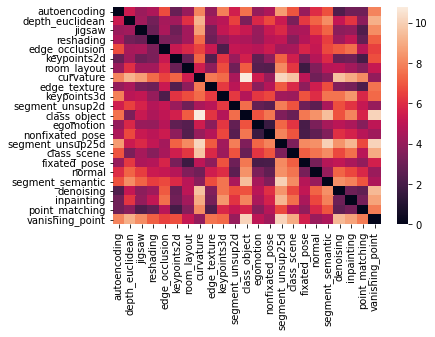

In [39]:
from itertools import combinations

rdm = pd.DataFrame(0, index=MODEL_NAMES, columns=MODEL_NAMES)

for c1, c2 in combinations(MODEL_NAMES, 2):
    rdm.loc[c1, c2] = (df.loc[c1] - df.loc[c2]).abs().sum()
    rdm.loc[c2, c1] = (df.loc[c1] - df.loc[c2]).abs().sum()

# norming dissimilarity: sum_abs_diff / (num_layers * 2)
sns.heatmap(rdm, xticklabels=rdm.columns, yticklabels=rdm.index)

target_rdm = rdm

# Predictor 1: semantic-2d-3d
Network grouping according to Radek paper <br>
[Finished predictor RDM ](#predictor-rdm-semantic-2d-3d)

In [222]:
NETS_SEMANTIC = ["class_object", "class_scene", "segment_semantic"]

# from radek paper missing: colorization (not downloadable from taskonomy)
NETS_2D = [
    "autoencoding",
    "denoising",
    "edge_texture",
    "inpainting",
    "keypoints2d",
    "segment_unsup2d",
]

# from radek paper missing: z-depth (missing from importing as well) and distance (but this is not a network after all)
NETS_3D = [
    "edge_occlusion",
    "keypoints3d",
    "segment_unsup25d",
    "reshading",
    "normal",
    "curvature",
]

NETS_ALL = NETS_SEMANTIC + NETS_2D + NETS_3D

# ratings
beauty_ratings = {}
for r in BEHAVIOUR_NAMES:

    data = (
        pd.read_csv(os.path.join(PATH_RATINGS, r), header=None)
        .mean(axis=1)
        .to_frame()
        .rename({0: "beauty rating"}, axis=1)
    )
    data.index.name = "img_id"

    # add name of study to index
    beauty_ratings[r] = pd.concat([data], names=["dataset"], keys=[r])

# integration
df1 = dfi.loc[(NETS_ALL, _dataset, _scale, slice(None)), :].droplevel(
    ["dataset", "scale"]
)
df1["class"] = df1.reset_index(level="model").model.apply(modelname2class).values
df1 = df1.set_index("class", append=True)

### visualize average integration of layers

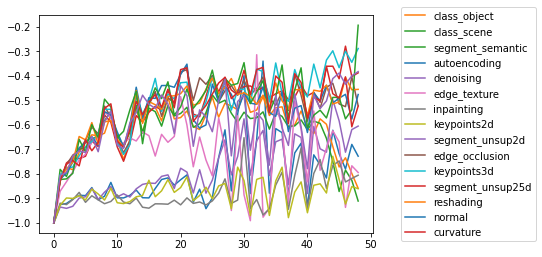

In [231]:
df_int_netavg = df1.groupby("model").mean().transpose()
handles, labels = df_int_netavg.plot().get_legend_handles_labels()

# already order legend by classes
order = [labels.index(netname) for netname in NETS_ALL]
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc="center right",
    bbox_to_anchor=(1.5, 0.5),
)

#### grouped by semantic-2d-3d

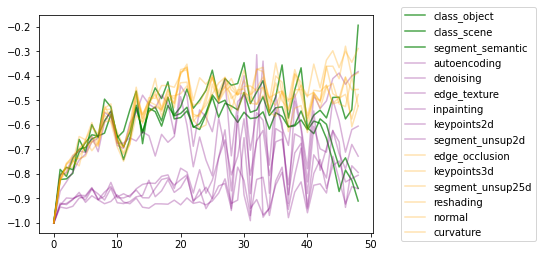

In [232]:
colors = (
    len(NETS_SEMANTIC) * ["green"]
    + len(NETS_2D) * ["purple"]
    + len(NETS_3D) * ["orange"]
)

for (netname, int_netavg), color in zip(df_int_netavg.iloc[:, order].items(), colors):
    if netname in NETS_SEMANTIC:
        alpha = 0.7
    else:
        alpha = 0.3
    plt.plot(int_netavg, label=netname, color=color, alpha=alpha)
    plt.legend(loc="center right", bbox_to_anchor=(1.5, 0.5))

## model RDM

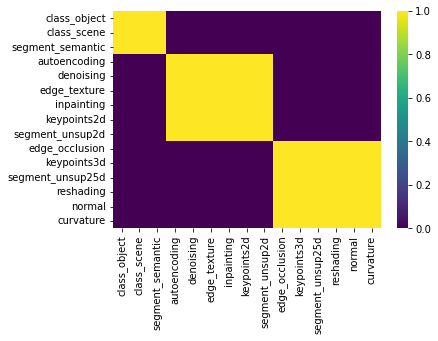

In [234]:
# create model RDM for semantiv-2D-3D nets integration
model_rdm = pd.DataFrame(
    np.full((len(NETS_ALL), len(NETS_ALL)), np.nan), columns=NETS_ALL, index=NETS_ALL
)

for combi in combinations_with_replacement(NETS_ALL, 2):
    if (
        combi in combinations_with_replacement(NETS_SEMANTIC, 2)
        or combi in combinations_with_replacement(NETS_2D, 2)
        or combi in combinations_with_replacement(NETS_3D, 2)
    ):
        model_rdm.loc[combi] = 1
        model_rdm.loc[tuple(reversed(combi))] = 1
    else:
        model_rdm.loc[combi] = 0
        model_rdm.loc[tuple(reversed(combi))] = 0

sns.heatmap(model_rdm, cmap="viridis");

## correlate RDM with model-RDM

### single layer

In [ ]:
layer_id = 48

# fitler relevant data
layer_df = pd.DataFrame(df.loc[NETS_ALL,"places1", "scale8"][layer_id]).reset_index()
# needed for pivot into wide format
layer_df["img_id"] = layer_df.groupby("model").cumcount()

# pivot
layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_id)

# reorder columns according to semantic-2D-3D nets
layer_df = layer_df[NETS_ALL]

rdm = calculate_rdm(layer_df, correlation_type="spearman")

pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
pearsonr(rdm.values.flatten(), model_rdm.values.flatten())

In [ ]:
sns.heatmap(rdm, cmap='viridis')

In [ ]:
xdm = rdm[rdm > .142].fillna(0)
sns.heatmap(xdm, cmap='viridis')

In [ ]:
xdm = rdm[rdm < 0].fillna(0)
sns.heatmap(xdm, cmap='viridis')

### all layers

In [ ]:
model_correlations = []
model_pvalues = []
# iterate layers
for layer_name, layer_series in df.loc[:,"places1", "scale8"].items():

    # put data back into DataFrame
    layer_df = pd.DataFrame(layer_series).reset_index()

    # needed for pivot into wide format
    layer_df["img_id"] = layer_df.groupby("model").cumcount()

    # pivot
    layer_df = layer_df.pivot(columns="model", index="img_id", values=layer_name)

    # reorder columns according to semantic-2D-3D nets
    layer_df = layer_df[NETS_ALL]

    rdm = calculate_rdm(layer_df, correlation_type="spearman")

    model_correlations.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[0])
    model_pvalues.append(pearsonr(rdm.values.flatten(), model_rdm.values.flatten())[1])

In [ ]:
alpha = 0.05

sns.lineplot(data=model_correlations)
plt.suptitle("Similarity in what is integrated")
plt.title("Correlation of taskonomy RDM with model (semantic-2D-3D) RDM")
plt.xlabel("Layer")
plt.ylabel("pearson correlation")


for x, layer_pvalue in enumerate(model_pvalues):
    if layer_pvalue < alpha:
        plt.scatter(x, 0, color='cyan', s=100, marker='o')


## variance partitioning of model classes

### average model classes

average integration values for each image from each category of networks

In [ ]:
df_int_classes = df_int.groupby(['dataset','img id', 'class']).mean()
df_int_classes

### convert to rank data
since the ib-correlation is the spearman correlation

just do OLS variance partitioning for now an then talk to daniel about it.

#### integration

In [ ]:
df_int_classes.columns.name = 'layer'
df_int_classes

In [ ]:
df_int_classes_ranks = (
    df_int_classes
    .unstack('class')
    .groupby('dataset')
    .rank()
    .astype(int)
)

df_icr = df_int_classes_ranks

df_icr

#### beauty

In [ ]:
df_beauty_ratings_rank = (
    pd.concat(beauty_ratings.values())
    .groupby('dataset')
    .rank()
    .astype(int))

df_brr = df_beauty_ratings_rank
df_brr

### create linear model

In [ ]:
# single study & layer
dataset = 'places1'
layer_idx = 48

df_icr.loc[dataset,layer_idx]

In [ ]:
for layer_id, layer in df_icr.groupby(level='layer', axis=1):
    pass

In [ ]:
for dataset_id, layer_dataset in layer.groupby(level='dataset', axis=0):
    pass

In [ ]:
layer_dataset

In [ ]:
df_icr.columns.get_level_values('layer')

In [ ]:
df_icr.index.get_level_values('dataset').unique()

In [ ]:
pd.DataFrame(np.nan,
             index=df_icr.index.get_level_values('dataset').unique(),
             columns=df_icr.columns.get_level_values('layer'))

In [ ]:
# how to present all these R2 values ?

In [ ]:
df_brr

In [ ]:
Y = df_brr.loc['study3_places2.csv',:].values
Y

In [ ]:
X = h.loc[:,(slice(None),'2d')].values
X

In [ ]:
OLS(Y, X).fit().rsquared

In [ ]:
def do_variance_partitioning():
    # do variance partitioning for one layer
    # i.e. for all unique, shared and full combinations of the three predictors
    # return dataframe with all R2 values
     

## predictor RDM (semantic-2d-3d)

The [model rdm](#model-rdm) is used as the predictors representing the semantic-2d-3d categorization, fill values for models not belonging to any class with zeros.

In [174]:
predictor_rdm_1 = pd.DataFrame(0, index=MODEL_NAMES, columns=MODEL_NAMES)
for c1, c2 in combinations_with_replacement(MODEL_NAMES, 2):
    if c1 in model_rdm.index and c2 in model_rdm.index:
        predictor_rdm_1.loc[c1, c2] = model_rdm.loc[c1, c2]
    else:
        predictor_rdm_1.loc[c1, c2] = 1

# Predictor 2:  integration profile across layers

RDM of RDM's that correlate integration ratings of each different layers inside each network.

[Finished predictor RDM](#predictor-rdm-layer-layer-similarity-inside-networks)

TODO: this essentially the same thing as absoloute correlation differences alone ?


In [ ]:
# copy code for each models layerXlayer RDM
# correlate correlations using daniels code

## load integration data

Same [integration data](#predictor-1-semantic-2d-3d) as before.

In [16]:
df1 = dfi.loc[(slice(None), slice(None), _scale, slice(None)), :].droplevel(
    ["scale"]
)
df1


0         1         2         3         4   \
model           dataset img                                                     
autoencoding    places1 0   -0.999991 -0.917922 -0.930811 -0.914774 -0.869516   
                        1   -0.999955 -0.951345 -0.914794 -0.899078 -0.898484   
                        2   -0.999948 -0.946175 -0.903166 -0.885057 -0.890593   
                        3   -0.999968 -0.937535 -0.934218 -0.916694 -0.897975   
                        4   -0.999962 -0.925314 -0.914676 -0.897472 -0.887411   
...                               ...       ...       ...       ...       ...   
vanishing_point oasis   895 -0.999956 -0.798612 -0.788502 -0.669378 -0.646601   
                        896 -0.999994 -0.621093 -0.652121 -0.458450 -0.480861   
                        897 -0.999986 -0.823186 -0.827352 -0.700241 -0.706266   
                        898 -0.999987 -0.600275 -0.717882 -0.646905 -0.505910   
                        899 -0.999964 -0.912630 -0.928350 -0.871105 -0.838053   

                                   5         6         7         8         9   \
model           dataset img                                                     
autoencoding    places1 0   -0.902136 -0.877531 -0.886417 -0.880856 -0.850519   
                        1   -0.910052 -0.872738 -0.917972 -0.894461 -0.861674   
                        2   -0.863178 -0.831387 -0.908985 -0.888226 -0.816422   
                        3   -0.914762 -0.886940 -0.915384 -0.897640 -0.865094   
                        4   -0.872304 -0.835715 -0.910505 -0.890380 -0.815658   
...                               ...       ...       ...       ...       ...   
vanishing_point oasis   895 -0.662750 -0.591443 -0.643661 -0.642419 -0.475076   
                        896 -0.549451 -0.488190 -0.562035 -0.595852 -0.419310   
                        897 -0.753884 -0.646171 -0.719115 -0.708331 -0.531127   
                        898 -0.602936 -0.527725 -0.549358 -0.553995 -0.381352   
                        899 -0.903252 -0.842005 -0.849038 -0.832068 -0.682499   

                             ...        39        40        41        42  \
model           dataset img  ...                                           
autoencoding    places1 0    ... -0.117163 -0.764329 -0.415537 -0.435197   
                        1    ... -0.897818 -0.990145 -0.880398 -0.921603   
                        2    ... -0.855676 -0.990495 -0.847510 -0.879954   
                        3    ... -0.155960 -0.875321 -0.589326 -0.457711   
                        4    ... -0.807627 -0.986187 -0.803042 -0.810347   
...                          ...       ...       ...       ...       ...   
vanishing_point oasis   895  ... -0.366059 -0.667875 -0.678267 -0.405754   
                        896  ... -0.490380 -0.716941 -0.710569 -0.569753   
                        897  ... -0.557119 -0.754066 -0.776372 -0.547503   
                        898  ... -0.398054 -0.673711 -0.689255 -0.493963   
                        899  ... -0.566247 -0.852588 -0.872386 -0.687743   

                                   43        44        45        46        47  \
model           dataset img                                                     
autoencoding    places1 0   -0.560172 -0.302064 -0.176622 -0.323419 -0.253195   
                        1   -0.922957 -0.793835 -0.893069 -0.895886 -0.801343   
                        2   -0.907064 -0.744677 -0.856094 -0.891321 -0.796056   
                        3   -0.734255 -0.614118 -0.451777 -0.657116 -0.710131   
                        4   -0.891486 -0.688937 -0.761859 -0.853884 -0.721088   
...                               ...       ...       ...       ...       ...   
vanishing_point oasis   895 -0.434410 -0.397831 -0.250873 -0.705020 -0.451089   
                        896 -0.598318 -0.541127 -0.448526 -0.781339 -0.649538   
                        897 -0.589784 -0.548064 -0.411440 -0.786431 -0.601113   
                        898 -0.506618 -0.524041

## version 1: layer X layer RDM for each network

In [46]:
v1_rdms_p1, v1_rdms_p2, v1_rdms_oa = {}, {}, {}
for mo, df_mo in df1.groupby("model"):
    v1_rdms_p1[mo] = calculate_rdm(df_mo.loc[(slice(None), "places1"), :])
    v1_rdms_p2[mo] = calculate_rdm(df_mo.loc[(slice(None), "places2"), :])
    v1_rdms_oa[mo] = calculate_rdm(df_mo.loc[(slice(None), "oasis"), :])

In [48]:
PATH = os.path.join(PATH_RESULTS, "layer profile", "version 1")
with open(os.path.join(PATH,"rmds places1.pkl"), "wb") as f:
    pickle.dump(v1_rdms_p1, f)

with open(os.path.join(PATH,"rmds places2.pkl"), "wb") as f:
    pickle.dump(v1_rdms_p2, f)

with open(os.path.join(PATH,"rmds oasis.pkl"), "wb") as f:
    pickle.dump(v1_rdms_oa, f)

In [49]:
PATH = os.path.join(PATH_RESULTS, "layer profile", "version 1")
with open(os.path.join(PATH, "rmds places1.pkl"), "rb") as f:
    v1_rdms_p1 = pickle.load(f)

with open(os.path.join(PATH, "rmds places2.pkl"), "rb") as f:
    v1_rdms_p2 = pickle.load(f)

with open(os.path.join(PATH, "rmds oasis.pkl"), "rb") as f:
    v1_rdms_oa = pickle.load(f)

In [52]:
df

ibcorr                                                    \
layer                   0         1         2         3         4         5    
model                                                                          
autoencoding      0.109319 -0.081112  0.002236  0.002929 -0.035421  0.013020   
class_object      0.036398 -0.093503 -0.097843 -0.090966 -0.136152 -0.152496   
class_scene       0.033445 -0.130991 -0.117985 -0.118130 -0.090534 -0.075194   
curvature         0.000352 -0.125555 -0.152378 -0.167088 -0.131711 -0.088394   
denoising         0.120938 -0.068358  0.018688  0.057166 -0.013896 -0.021107   
depth_euclidean   0.012650 -0.139861 -0.189989 -0.160197 -0.122983 -0.084288   
edge_occlusion    0.018985 -0.116049 -0.172774 -0.151114 -0.179478 -0.133200   
edge_texture      0.015580 -0.123250 -0.163263 -0.160193 -0.181494 -0.114908   
egomotion         0.091012 -0.062869 -0.076634 -0.108860 -0.122739 -0.152356   
fixated_pose      0.089525 -0.100744 -0.129219 -0.154314 -0.105257 -0.132073   
inpainting        0.088669 -0.098428 -0.093721 -0.111457 -0.040922 -0.057128   
jigsaw            0.084274 -0.100964 -0.111920 -0.105982 -0.107555 -0.098781   
keypoints2d       0.050392 -0.070680 -0.080440 -0.093706 -0.114780 -0.119188   
keypoints3d      -0.009716 -0.126614 -0.164878 -0.128915 -0.155539 -0.128361   
nonfixated_pose   0.096954 -0.085664 -0.077464 -0.068578 -0.116328 -0.098001   
normal           -0.050539 -0.127319 -0.191322 -0.227292 -0.157770 -0.075633   
point_matching    0.091357 -0.127261 -0.118134 -0.131597 -0.106754 -0.074639   
reshading         0.013004 -0.125953 -0.146751 -0.144984 -0.184769 -0.105184   
room_layout       0.069977 -0.108234 -0.121382 -0.098226 -0.100634 -0.075855   
segment_semantic  0.092262 -0.108453 -0.088245 -0.049769 -0.110669 -0.096545   
segment_unsup25d  0.021194 -0.123609 -0.170581 -0.170598 -0.159346 -0.143841   
segment_unsup2d   0.057770 -0.146864 -0.209783 -0.172318 -0.218582 -0.192770   
vanishing_point   0.063196 -0.097244 -0.117646 -0.171693 -0.155305 -0.093264   

                                                          ...            \
layer                   6         7         8         9   ...        39   
model                                                     ...             
autoencoding     -0.010661 -0.006671 -0.047561 -0.009812  ... -0.020506   
class_object     -0.166138 -0.119782 -0.098213 -0.095330  ...  0.101754   
class_scene      -0.089023 -0.092821 -0.117358 -0.151288  ...  0.305645   
curvature        -0.103136 -0.107259 -0.124352 -0.108418  ... -0.295837   
denoising        -0.059497 -0.070813 -0.081520 -0.069021  ...  0.026784   
depth_euclidean  -0.089047 -0.088544 -0.043081 -0.102110  ... -0.041855   
edge_occlusion   -0.148768 -0.097778 -0.127201 -0.119764  ...  0.100721   
edge_texture     -0.145120 -0.110258 -0.101347 -0.122791  ... -0.170410   
egomotion        -0.183068 -0.105884 -0.168894 -0.162158  ... -0.115516   
fixated_pose     -0.116650 -0.083438 -0.067999 -0.100603  ... -0.155098   
inpainting       -0.054835 -0.027799 -0.006350  0.009689  ... -0.073614   
jigsaw           -0.110286 -0.114013 -0.132649 -0.152130  ...  0.128154   
keypoints2d      -0.140009 -0.095158 -0.083681 -0.111648  ... -0.092146   
keypoints3d      -0.132462 -0.081396 -0.080059 -0.117290  ...  0.352681   
nonfixated_pose  -0.133594 -0.116592 -0.118333 -0.162753  ... -0.201905   
normal           -0.066988 -0.106548 -0.099741 -0.117193  ... -0.107309   
point_matching   -0.059467 -0.096038 -0.131767 -0.137284  ... -0.034694   
reshading        -0.112838 -0.113424 -0.121482 -0.098478  ...  0.148204   
room_layout      -0.109026 -0.091016 -0.116499 -0.145292  ... -0.126546   
segment_semantic -0.111349 -0.113549 -0.125037 -0.109318  ... -0.414207   
segment_unsup25d -0.149463 -0.186771 -0.130901 -0.167126  ...  0.191098   
segment_unsup2d  -0.196534 -0.152172 -0.130157 -0.194694  ... -0.082191   
vanishing_point  -0.143874 -0.144033 -0.169158 -0.258797  ... -0

In [53]:
import pandas as pd

# Example DataFrame
tmp = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
})

# Save to CSV
df.to_csv(os.path.join(PATH_RESULTS,'data.csv'), index=True)


## version 2: integration in best layer

ordering of images by integration in best predicting layer

"what is integrated", alternatively average of correlation between in each layer, howevery layers may not correspond to each other, therefore best predicting layer is more general <br> <br>

Interpretation: The differences in absolout values correspond to how similar the "integration mechanism" in both networks are.<br> If we assume that beauty perception depends on a specific stage of processing and not the whole processing stream, then the best predicting layer of a network can be interpreted as the point, where the network best mimics the aspects of the processing that determine beauty. <br> 

If the a similar The value in Is there a single or are there different ways of predicting beauty ?`

### get best predicting layer in each model

### correlate integration values of best predicting layers

## predictor RDM: correlate network RDMs

In [34]:
# put RDMs into columns
# throw out zeros on diagonal to avoid skewing correlation (standard RSA procedure)
RDMs_places1  = pd.DataFrame(columns=MODEL_NAMES)

for network_name, rdm in v1_rdms_p1.items():
    # mark diagonal values (all zeros)for removal
    np.fill_diagonal(rdm.values, np.nan)
    RDMs_places1.loc[:,network_name] = rdm.values.flatten()

# removed marked diagonal values
RDMs_places1 = RDMs_places1.dropna()

print("Should be (2353, 15)")
RDMs_places1.shape

Should be (2353, 15)


(2352, 23)

In [36]:
predictor_rdm_2 = calculate_rdm(RDMs_places1)

# Predictor 3: spatial integration

"how"

"where" or alternatively "what",  which is the same because its spatial integration. Check for correlation between the what (represented by the integration ratings).

DONE IN SEPERATE NOTEBOOK

## integration is localized

### run integration searchlight analysis

In [ ]:
# visualize node score distribution

In [ ]:
# visualize within layer heatmaps

# exemplars



In [ ]:
# spatial correlation per image per net, correlate these netXnet
# test if integration scores are still correlating to beauty

# Predictor 4: New predictor: Image representations of network


# GLM (Predictors, Target)
do for each study and each scale, to check if there is some consistency in which factors always comes out on top

In [173]:
# predictor 1 alone
pearsonr(target_rdm.values.flatten(), predictor_rdm_1.values.flatten())

(-0.25174930486826097, 4.322319604268717e-09)

In [40]:
# predictor 2 alone
pearsonr(target_rdm.values.flatten(), predictor_rdm_2.values.flatten())

(0.08131217692109446, 0.06164345778947235)

In [ ]:
# variance partitioning between different predictors